In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import eco2ai
import scipy
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from numpy import linalg as LA
from carbontracker.tracker import CarbonTracker

In [2]:
#from pypapi import events, papi_high as high

In [3]:
tracker = eco2ai.Tracker(project_name="DNL", experiment_description="Training DNL")

C:\Users\aghalkha21\AppData\Roaming\Python\Python38\site-packages\eco2ai\emission_track.py:128: UserWarning: 
    If you use a VPN, you may have problems with identifying your country by IP.
    It is recommended to disable VPN or
    manually install the ISO-Alpha-2 code of your country during initialization of the Tracker() class.
    You can find the ISO-Alpha-2 code of your country here: https://www.iban.com/country-codes
    
  warnings.warn(


In [4]:
seed = 42
no_users = 100
lambda_logistic = 1e-3

In [5]:
def random_split(X, y, n, seed):
    """Equally split data between n agents"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(y.size)
    X_split = np.array_split(X[perm], n)  #np.stack to keep as a np array
    y_split = np.array_split(y[perm], n)
    return X_split, y_split

In [6]:
def loss(w, A, b, l2):
    z = b * np.dot(A, w)
    tmp = np.minimum(z, 0)
    loss = np.log((np.exp(tmp) + np.exp(tmp - z)) / np.exp(tmp))
    loss_sum = np.sum(loss) / len(b)
    reg = (np.linalg.norm(w) ** 2) * l2 / 2
    return loss_sum + reg

In [7]:
def gradient(w, A, b, l2):
    m = A.shape[0]
    z = b * np.dot(A, w)
    tmp0 = np.minimum(z, 0)
    tmp1 = np.exp(tmp0 - z) / ((np.exp(tmp0) + np.exp(tmp0 - z)))
    tmp2 = - tmp1 * b
    res = np.dot(A.T, tmp2) / m + l2 * w
    return res

In [8]:
def hessian(w, A, b, l2):
    Aw = A @ w
    activation = scipy.special.expit(Aw)
    weights = activation * (1-activation)
    A_weighted = np.multiply(A.T, weights)
    return A_weighted@A/A.shape[0] + l2*np.eye(A.shape[1])

In [9]:
def degrees(A):
    """Return the degrees of each node of a graph from its adjacency matrix"""
    return np.sum(A, axis=0).reshape(A.shape[0], 1)

In [10]:
def generate_graph(n, seed):
    """Generate a random connected graph"""
    while True:
        # g = nx.generators.random_graphs.binomial_graph(n, 0.4, seed = seed) 
        g = nx.random_geometric_graph(n, 0.4, seed = seed)
        #g = nx.grid_2d_graph(int(n/5), int(n/5))
        if nx.algorithms.components.is_connected(g):
            return g

1654
100


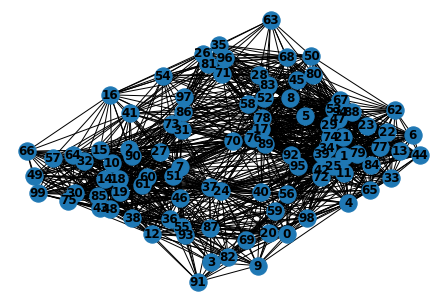

In [11]:
G = generate_graph(no_users, seed)
adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
print(G.number_of_edges())
print(G.number_of_nodes())
nx.draw(G, with_labels=True, font_weight='bold')

In [12]:
X = np.load('X.npy')
y = np.load('y.npy').ravel()

num_feature = X.shape[1] #+ 1 #+1 for bias

In [13]:

X, y = random_split(X, y, no_users, seed)

theta = [np.zeros(num_feature) for _ in range(no_users)] # initial model

d_new = [np.zeros(num_feature) for _ in range(no_users)] # direction
d_old = [np.zeros(num_feature) for _ in range(no_users)] # old direction

lamd = [np.zeros(num_feature) for _ in range(no_users)] # dual variables

grad = [np.zeros(num_feature) for _ in range(no_users)] # old grads
Hess = [np.zeros([num_feature, num_feature]) for _ in range(no_users)] # old hessians

In [14]:
print(X[0].shape)

(110, 40)


In [15]:
# Optimal objective function, i.e., f(x*)
obj0 = 0.31939515938637913 # phishing dataset

In [16]:
n_iters = 20
rho =[0.001 for t in range(n_iters)]
alpha = 20 * rho[0]
# Best: rho=0.0005, alpha = 0.02
from carbontracker import parser



In [17]:
losses_dnl = []
accuracies_dnl = []
op_gap_dnl = np.zeros(shape=[n_iters])
#tracker = CarbonTracker(epochs=n_iters)
for k in range(n_iters):
    #print(k)
    tracker.start()
    for i in range(no_users):       
        grad[i] = gradient(theta[i], X[i], y[i], lambda_logistic)
        Hess[i] = hessian(theta[i], X[i], y[i], lambda_logistic)
    
    for i in range(no_users):
        w_neighbors_sum = np.zeros(num_feature)
        for j in G.neighbors(i):
            w_neighbors_sum = np.add(w_neighbors_sum, d_old[j])
        degree = G.degree(i)
        d_new[i] = np.matmul(np.linalg.inv(Hess[i] + (2 * degree * rho[k] + alpha) * np.eye(num_feature)),\
                                        grad[i] - lamd[i] + rho[k] * (degree * d_old[i] + w_neighbors_sum))
            

  
    # Dual Variable Update
    for i in range(no_users):
        w_neighbors_sum = np.zeros(num_feature)
        for j in G.neighbors(i):
            w_neighbors_sum = np.add(w_neighbors_sum, d_new[j])
        degree = G.degree(i)
        lamd[i] = lamd[i] + rho[k] * (degree * d_new[i] - w_neighbors_sum)
   # print('dual: ', LA.norm(lamd[0]))
     
        
    for i in range(no_users):
        theta[i] = theta[i] - d_new[i]
        d_old[i] = d_new[i]
    tracker.stop()
    
   # Performance Check
    
    #theta_avg = 1/no_users*sum(theta)
    
    #for i in range(no_users):
        #loss_dnl = np.mean([loss(theta_avg, X[i], y[i], lambda_logistic) for i in range(no_users)])
        #losses_dnl.append(loss_dnl)
    
    #op_gap_dnl[k] = np.abs(losses_dnl[-1] - obj0)

C:\Users\aghalkha21\AppData\Roaming\Python\Python38\site-packages\eco2ai\tools\tools_cpu.py:240: NoNeededLibrary: 
It's impossible to deretmine cpu number correctly
For now, number of cpu devices is set to 1


  warnings.warn(message="\nIt's impossible to deretmine cpu number correctly\nFor now, number of cpu devices is set to 1\n\n",
C:\Users\aghalkha21\AppData\Roaming\Python\Python38\site-packages\eco2ai\tools\tools_gpu.py:35: NoGPUWarning: 

There is no any available GPU devices or your GPU is not supported by Nvidia library!
The tracker will consider CPU usage only

  warnings.warn(message="\n\nThere is no any available GPU devices or your GPU is not supported by Nvidia library!\nThe tracker will consider CPU usage only\n",
C:\Users\aghalkha21\AppData\Roaming\Python\Python38\site-packages\eco2ai\tools\tools_cpu.py:240: NoNeededLibrary: 
It's impossible to deretmine cpu number correctly
For now, number of cpu devices is set to 1


  warnings.warn(message="\nIt's impossible to deretm

C:\Users\aghalkha21\AppData\Roaming\Python\Python38\site-packages\eco2ai\tools\tools_cpu.py:240: NoNeededLibrary: 
It's impossible to deretmine cpu number correctly
For now, number of cpu devices is set to 1


  warnings.warn(message="\nIt's impossible to deretmine cpu number correctly\nFor now, number of cpu devices is set to 1\n\n",
C:\Users\aghalkha21\AppData\Roaming\Python\Python38\site-packages\eco2ai\tools\tools_gpu.py:35: NoGPUWarning: 

There is no any available GPU devices or your GPU is not supported by Nvidia library!
The tracker will consider CPU usage only

  warnings.warn(message="\n\nThere is no any available GPU devices or your GPU is not supported by Nvidia library!\nThe tracker will consider CPU usage only\n",
C:\Users\aghalkha21\AppData\Roaming\Python\Python38\site-packages\eco2ai\tools\tools_cpu.py:240: NoNeededLibrary: 
It's impossible to deretmine cpu number correctly
For now, number of cpu devices is set to 1


  warnings.warn(message="\nIt's impossible to deretm

# Optimality Gap

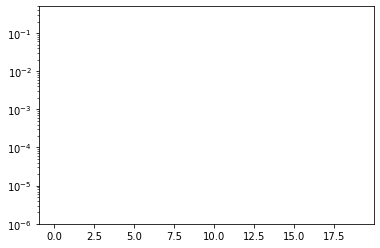

In [18]:
import matplotlib.pyplot as plt
plt.semilogy(op_gap_dnl)
plt.ylim([10**(-6),0.5])
np.save('op_gap_dnl', op_gap_dnl)

In [20]:
import pandas as pd
emission = pd.read_csv('dnl_emission.csv')
emission.head(10)
#parser.print_aggregate(log_dir="./my_log_directory/")

,id,project_name,experiment_description,epoch,start_time,duration(s),power_consumption(kWh),CO2_emissions(kg),CPU_name,GPU_name,OS,region/country,cost
0,8a37329d-5995-435f-b6a5-98becf1a27af,DNL,Training DNL,NaN,2022-10-10 09:48:26,12.721264,6.982640e-08,9.906970e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
1,64071da1-3d72-425c-8904-eef02078ccc3,DNL,Training DNL,NaN,2022-10-10 09:48:52,12.590112,6.436282e-08,9.131797e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
2,1df8c62b-10b6-42ac-a585-47455b5a9fb8,DNL,Training DNL,NaN,2022-10-10 09:49:18,12.376967,6.671256e-08,9.465178e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
3,1b61fe26-4ec4-45c8-9382-649ac28d79b4,DNL,Training DNL,NaN,2022-10-10 09:49:44,12.240892,6.220407e-08,8.825513e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
4,24587678-5bf8-4eff-9df8-08c223b86f9d,DNL,Training DNL,NaN,2022-10-10 09:50:11,13.330083,8.388050e-08,1.190097e-08,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
5,4f27abf3-5742-4bbe-bf1f-5e319324da79,DNL,Training DNL,NaN,2022-10-10 09:50:37,12.433225,6.949860e-08,9.860462e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
6,6302ab83-4618-40e2-9592-a8c38d422968,DNL,Training DNL,NaN,2022-10-10 09:51:03,12.178251,6.591837e-08,9.352498e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
7,5660b642-1d9b-4bfc-8448-63b7835cad68,DNL,Training DNL,NaN,2022-10-10 09:51:28,12.231138,6.323270e-08,8.971456e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
8,36985ac9-ce28-4fd8-b8f8-e78557073b88,DNL,Training DNL,NaN,2022-10-10 09:51:53,12.085656,6.507404e-08,9.232705e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
9,08aece9d-9932-4b15-bf2d-55a0584df65e,DNL,Training DNL,NaN,2022-10-10 09:52:19,12.128933,6.018172e-08,8.538582e-09,Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz/1 de...,0 device(s),Windows,FI/North Ostrobothnia,NaN
